https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_binary_classification_product_backorders.ipynb
    
# H2O AutoML Binary Classification Demo: porto_seguro

This is a Jupyter Notebook. When you execute code within the notebook, the results appear beneath the code. To execute a code chunk, place your cursor on the cell and press Shift+Enter.

## Start H2O

Import the `h2o` Python module and `H2OAutoML` class and initialize a local H2O cluster.

In [1]:
import h2o
from h2o.automl import H2OAutoML

import numpy as np
import pandas as pd

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_372"; OpenJDK Runtime Environment (build 1.8.0_372-b07); OpenJDK 64-Bit Server VM (build 25.372-b07, mixed mode)
  Starting server from /home/stever7/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp40xt0qvc
  JVM stdout: /tmp/tmp40xt0qvc/h2o_stever7_started_from_python.out
  JVM stderr: /tmp/tmp40xt0qvc/h2o_stever7_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"1 year, 4 months and 19 days !!!"
H2O_cluster_name:,H2O_from_python_stever7_seuhw0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,26.62 Gb
H2O_cluster_total_cores:,64
H2O_cluster_allowed_cores:,64
H2O_cluster_status:,"locked, healthy"


## Load Data

For the AutoML binary classification demo, we use a subset of the Product Backorders dataset: 

https://www.kaggle.com/tiredgeek/predict-bo-trial/data

The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [3]:
# Use local data file or download from GitHub

# import os

# docker_data_path = "/home/h2o/data/automl/product_backorders.csv"

# if os.path.isfile(docker_data_path):
#   data_path = docker_data_path
# else:
#   data_path = "https://github.com/h2oai/h2o-tutorials/raw/master/h2o-world-2017/automl/data/product_backorders.csv"

In [4]:
# Load data into H2O
# df = h2o.import_file(data_path)
train_df = pd.read_csv("porto_train.csv")
test_df = pd.read_csv("porto_test.csv")

For classification, the response should be encoded as categorical (aka. "factor" or "enum"). Let's take a look.

In [5]:
train_df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,fold
count,4.761700e+05,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,...,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000,476170.000000
mean,7.434826e+05,0.036455,1.899899,1.358710,4.424136,0.416748,0.406115,0.393009,0.257272,0.164204,...,1.441105,2.873029,7.535775,0.122444,0.627992,0.553943,0.287339,0.349302,0.153057,3.000000
std,4.294954e+05,0.187421,1.983306,0.664186,2.699944,0.493328,1.351574,0.488419,0.437131,0.370461,...,1.201951,1.695936,2.744812,0.327798,0.483341,0.497082,0.452521,0.476750,0.360043,1.414215
min,9.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.713358e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7.430715e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000
75%,1.115286e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000
max,1.488021e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [6]:
train_df = train_df.replace(-1, np.nan)
test_df = test_df.replace(-1, np.nan)

In [7]:
cat_vars = [col for col in train_df.columns if 'cat' in col]
cat_vars

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [8]:
train_df = h2o.H2OFrame(train_df)
test_df = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We will notice that the response column, `"went_on_backorder"`, is already encoded as "enum", so there's nothing we need to do here. If it were encoded as a 0/1 "int", then we'd have to convert the column as follows: 

```
df[y] = df[y].asfactor()
```

Next, let's identify the response and predictor columns by saving them as `x` and `y`. The `"sku"` column is a unique identifier so we'll want to remove that from the set of our predictors.

In [9]:
# y = "went_on_backorder"
# x = df.columns
# x.remove(y)
# x.remove("sku")

In [10]:
target = "target"

In [11]:
predictors = train_df.columns
predictors.remove(target)  # remove "target"
predictors.remove("id")  # remove "id" (should not be a predictor)
predictors.remove("fold")  # remove "fold" (not be a predictor)

In [12]:
for col in cat_vars:
    test_df[col] = test_df[col].asfactor()
    
cat_vars = cat_vars + ["target"]

for col in cat_vars:
    train_df[col] = train_df[col].asfactor()

## Run AutoML

Run AutoML, stopping after 10 models. The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [13]:
# aml = H2OAutoML(max_models=10, seed=1)
aml = H2OAutoML(max_runtime_secs=3600, seed=1, sort_metric="AUC")
# aml.train(x=x, y=y, training_frame=train_df)
aml.train(x=predictors, y=target, training_frame=train_df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

13:43:59.226: GBM_lr_annealing_selection_AutoML_1_20230706_124357 [GBM lr_annealing] failed: water.exceptions.H2OIllegalArgumentException: Can only convert jobs producing a single Model or ModelContainer.

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_1_20230706_124357

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.033052956493957404
RMSE: 0.1818047207691742
LogLoss: 0.13944782652039922
Null degrees of freedom: 9852
Residual degrees of freedom: 9818
Null deviance: 3043.629546252695
Residual deviance: 2747.9588694109866
AIC: 2817.9588694109866
AUC: 0.7745834203071418
AUCPR: 0.17698161636831342
Gini: 0.5491668406142836

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06895280542813947: 


,,0,1,Error,Rate
0,0,9009.0,491.0,0.0517,(491.0/9500.0)
1,1,238.0,115.0,0.6742,(238.0/353.0)
2,Total,9247.0,606.0,0.074,(729.0/9853.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.068953,0.239833,118.0
1,max f2,0.049671,0.311297,182.0
2,max f0point5,0.094357,0.249781,67.0
3,max accuracy,0.176870,0.964782,7.0
4,max precision,0.247051,1.000000,0.0
5,max recall,0.015229,1.000000,379.0
6,max specificity,0.247051,1.000000,0.0
7,max absolute_mcc,0.068953,0.212038,118.0
8,max min_per_class_accuracy,0.039431,0.695474,228.0
9,max mean_per_class_accuracy,0.039431,0.700428,228.0



Gains/Lift Table: Avg response rate:  3.58 %, avg score:  3.63 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010048,0.109336,9.586002,9.586002,0.343434,0.137013,0.343434,0.137013,0.096317,0.096317,858.600166,858.600166,0.089475
1,2,0.020095,0.093802,6.484648,8.035325,0.232323,0.100953,0.287879,0.118983,0.065156,0.161473,548.464818,703.532492,0.146631
2,3,0.030042,0.084544,4.841909,6.978045,0.173469,0.088539,0.250000,0.108904,0.048159,0.209632,384.190900,597.804533,0.186263
3,4,0.040089,0.077518,3.947177,6.218410,0.141414,0.080831,0.222785,0.101868,0.039660,0.249292,294.717715,521.841001,0.216976
4,5,0.050036,0.072660,3.417818,5.661700,0.122449,0.074928,0.202840,0.096513,0.033994,0.283286,241.781812,466.170006,0.241918
5,6,0.100071,0.059187,2.208063,3.934882,0.079108,0.065081,0.140974,0.080797,0.110482,0.393768,120.806302,293.488154,0.304610
6,7,0.150005,0.052083,2.155819,3.342663,0.077236,0.055528,0.119756,0.072385,0.107649,0.501416,115.581888,234.266312,0.364469
7,8,0.200041,0.047118,1.415425,2.860609,0.050710,0.049436,0.102486,0.066645,0.070822,0.572238,41.542502,186.060914,0.386027
8,9,0.300010,0.040282,1.076815,2.266212,0.038579,0.043410,0.081191,0.058902,0.107649,0.679887,7.681512,126.621228,0.393992
9,10,0.399980,0.035565,0.906792,1.926443,0.032487,0.037829,0.069018,0.053635,0.090652,0.770538,-9.320832,92.644337,0.384328




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.03473781091097836
RMSE: 0.18638082227251376
LogLoss: 0.15182589455705398
Null degrees of freedom: 476169
Residual degrees of freedom: 476136
Null deviance: 149054.489805372
Residual deviance: 144589.87242246477
AIC: 144657.87242246477
AUC: 0.6414084693866706
AUCPR: 0.06723005941096553
Gini: 0.28281693877334124

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05962829347270288: 


,,0,1,Error,Rate
0,0,413628.0,45183.0,0.0985,(45183.0/458811.0)
1,1,13430.0,3929.0,0.7737,(13430.0/17359.0)
2,Total,427058.0,49112.0,0.1231,(58613.0/476170.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.059628,0.118217,186.0
1,max f2,0.039754,0.200041,257.0
2,max f0point5,0.081357,0.099219,137.0
3,max accuracy,0.403766,0.963553,6.0
4,max precision,0.481257,0.750000,2.0
5,max recall,0.009669,1.000000,398.0
6,max specificity,0.563126,0.999998,0.0
7,max absolute_mcc,0.045106,0.081712,234.0
8,max min_per_class_accuracy,0.035260,0.600095,278.0
9,max mean_per_class_accuracy,0.035090,0.600849,279.0



Gains/Lift Table: Avg response rate:  3.65 %, avg score:  3.65 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010001,0.111659,3.525327,3.525327,0.128517,0.140534,0.128517,0.140534,0.035255,0.035255,252.532660,252.532660,0.026210
1,2,0.020001,0.094685,2.609433,3.067380,0.095128,0.102028,0.111823,0.121281,0.026096,0.061351,160.943293,206.737976,0.042915
2,3,0.030002,0.085244,2.246532,2.793764,0.081898,0.089637,0.101848,0.110733,0.022467,0.083818,124.653166,179.376373,0.055852
3,4,0.040000,0.078877,2.223957,2.651335,0.081075,0.081870,0.096656,0.103519,0.022236,0.106054,122.395733,165.133457,0.068553
4,5,0.050001,0.074024,2.039160,2.528894,0.074339,0.076335,0.092192,0.098082,0.020393,0.126447,103.915950,152.889441,0.079339
5,6,0.100000,0.060074,1.891854,2.210381,0.068968,0.066132,0.080580,0.082107,0.094591,0.221038,89.185378,121.038078,0.125618
6,7,0.150001,0.052479,1.525401,1.982051,0.055609,0.055986,0.072257,0.073400,0.076272,0.297310,52.540146,98.205114,0.152882
7,8,0.200000,0.047373,1.394119,1.835071,0.050823,0.049785,0.066898,0.067496,0.069704,0.367014,39.411880,83.507114,0.173333
8,9,0.300000,0.040377,1.201106,1.623749,0.043787,0.043611,0.059195,0.059535,0.120111,0.487125,20.110605,62.374945,0.194205
9,10,0.400000,0.035482,1.072066,1.485829,0.039083,0.037814,0.054167,0.054104,0.107207,0.594331,7.206636,48.582868,0.201684


*Note: If you see the following error, it means that you need to install the pandas module.*

```
H2OTypeError: Argument `python_obj` should be a None | list | tuple | dict | numpy.ndarray | pandas.DataFrame | scipy.sparse.issparse, got H2OTwoDimTable 
```

## Leaderboard

Next, we will view the AutoML Leaderboard. Since we did not specify a `leaderboard_frame` in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at `aml.leaderboard`.

In [14]:
lb = aml.leaderboard

Now we will view a snapshot of the top models. Here we should see the two Stacked Ensembles at or near the top of the leaderboard. Stacked Ensembles can almost always outperform a single model.

In [15]:
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_4_AutoML_1_20230706_124357,0.641408,0.151826,0.0672301,0.43607,0.186381,0.0347378
StackedEnsemble_AllModels_3_AutoML_1_20230706_124357,0.64126,0.151841,0.0671934,0.431667,0.186385,0.0347394
StackedEnsemble_BestOfFamily_4_AutoML_1_20230706_124357,0.639196,0.151982,0.0660473,0.429298,0.186431,0.0347563
StackedEnsemble_AllModels_2_AutoML_1_20230706_124357,0.637682,0.152083,0.0654523,0.436112,0.186455,0.0347656
XGBoost_grid_1_AutoML_1_20230706_124357_model_16,0.637397,0.152084,0.0658065,0.436697,0.186446,0.0347621
StackedEnsemble_BestOfFamily_3_AutoML_1_20230706_124357,0.637247,0.152107,0.0653603,0.432217,0.186461,0.0347676
XGBoost_grid_1_AutoML_1_20230706_124357_model_23,0.636553,0.152138,0.0655165,0.431297,0.186462,0.0347679
StackedEnsemble_AllModels_1_AutoML_1_20230706_124357,0.635232,0.152293,0.0635048,0.431319,0.186528,0.0347928
GBM_grid_1_AutoML_1_20230706_124357_model_14,0.635137,0.152344,0.0639354,0.43322,0.186528,0.0347928
XGBoost_grid_1_AutoML_1_20230706_124357_model_25,0.634298,0.152316,0.064849,0.442902,0.186506,0.0347844


To view the entire leaderboard, specify the `rows` argument of the `head()` method as the total number of rows:

In [16]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_4_AutoML_1_20230706_124357,0.641408,0.151826,0.0672301,0.43607,0.186381,0.0347378
StackedEnsemble_AllModels_3_AutoML_1_20230706_124357,0.64126,0.151841,0.0671934,0.431667,0.186385,0.0347394
StackedEnsemble_BestOfFamily_4_AutoML_1_20230706_124357,0.639196,0.151982,0.0660473,0.429298,0.186431,0.0347563
StackedEnsemble_AllModels_2_AutoML_1_20230706_124357,0.637682,0.152083,0.0654523,0.436112,0.186455,0.0347656
XGBoost_grid_1_AutoML_1_20230706_124357_model_16,0.637397,0.152084,0.0658065,0.436697,0.186446,0.0347621
StackedEnsemble_BestOfFamily_3_AutoML_1_20230706_124357,0.637247,0.152107,0.0653603,0.432217,0.186461,0.0347676
XGBoost_grid_1_AutoML_1_20230706_124357_model_23,0.636553,0.152138,0.0655165,0.431297,0.186462,0.0347679
StackedEnsemble_AllModels_1_AutoML_1_20230706_124357,0.635232,0.152293,0.0635048,0.431319,0.186528,0.0347928
GBM_grid_1_AutoML_1_20230706_124357_model_14,0.635137,0.152344,0.0639354,0.43322,0.186528,0.0347928
XGBoost_grid_1_AutoML_1_20230706_124357_model_25,0.634298,0.152316,0.064849,0.442902,0.186506,0.0347844


## Ensemble Exploration

To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [17]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:, 0])

# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])

# Get the Stacked Ensemble metalearner model
metalearner = se.metalearner()

Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [18]:
metalearner.coef_norm()

{'Intercept': -3.3922003747302925,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_16': 0.013103647915165785,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_23': 0.0408019342442552,
 'GBM_grid_1_AutoML_1_20230706_124357_model_14': 0.021592717709597392,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_25': 0.019351784912389935,
 'GBM_grid_1_AutoML_1_20230706_124357_model_7': 0.060949626317505036,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_21': 0.07834578173823378,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_20': 0.05310631799727189,
 'XGBoost_3_AutoML_1_20230706_124357': 0.025359295228995573,
 'GBM_grid_1_AutoML_1_20230706_124357_model_20': 0.0,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_15': 0.028007582274494087,
 'GBM_grid_1_AutoML_1_20230706_124357_model_11': 0.0,
 'GBM_grid_1_AutoML_1_20230706_124357_model_22': 0.0030726859118833626,
 'XGBoost_grid_1_AutoML_1_20230706_124357_model_18': 0.003456085500911957,
 'GBM_grid_1_AutoML_1_20230706_124357_model_2': 0.0,
 'XGBoost

We can also plot the base learner contributions to the ensemble.

AttributeError: 'Line2D' object has no attribute '_legmarker'

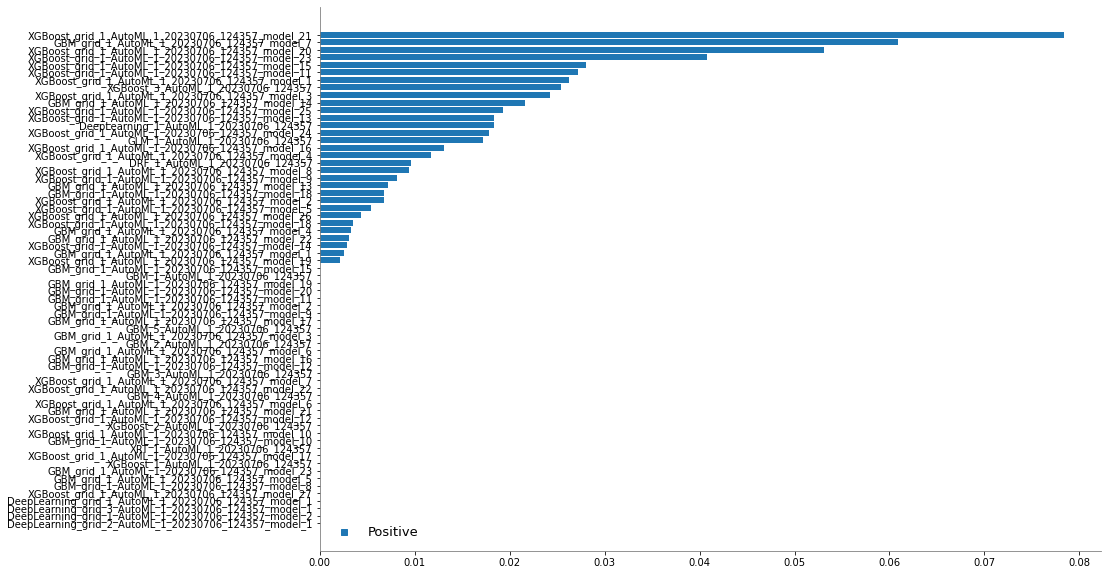

In [19]:
# %matplotlib inline

metalearner.std_coef_plot()

## Save Leader Model

There are two ways to save the leader model: binary format and MOJO format. If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [ ]:
# h2o.save_model(aml.leader, path = "./porto_model_bin")

In [ ]:
# aml.leader.download_mojo(path = "./")